In [34]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight
import numpy as np

In [35]:

img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 64

# Specify the paths to your train, validation, and test data
train_dir = 'D:\Dataset\FIX CLAHE Resized Oversampled\\train'
val_dir = 'D:\Dataset\FIX CLAHE Resized Oversampled\\val'
test_dir = 'D:\Dataset\FIX CLAHE Resized Oversampled\\test'

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle = False
)

Found 10464 images belonging to 4 classes.
Found 1308 images belonging to 4 classes.
Found 1308 images belonging to 4 classes.


In [36]:
# from sklearn.utils import class_weight
# import numpy as np

# class_counts = np.unique(train_generator.classes, return_counts=True)

# class_weights = class_weight.compute_class_weight(
#     'balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )

# # Ubah array bobot menjadi dictionary
# class_weights_dict = {class_label: weight for class_label, weight in zip(class_counts[0], class_weights)}

# print(class_weights_dict)

In [37]:
# Get class indices from the training generator
class_indices = train_generator.class_indices

# Count the number of images in each class
num_images_per_class_train = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_indices.keys()}

# Print the results
print("Number of images in each class for the training set:")
for class_name, num_images in num_images_per_class_train.items():
    print(f"{class_name}: {num_images} images")


Number of images in each class for the training set:
COVID-19: 2616 images
Normal: 2616 images
Pneumonia-Bacterial: 2616 images
Pneumonia-Viral: 2616 images


In [38]:
# Load the VGG16 model with pretrained weights (excluding the top dense layers)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()

# Add the base model
model.add(base_model)

# Flatten the output layer to 1 dimension
model.add(layers.Flatten())

# Add a fully connected layer with 256 hidden units, ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add a dropout layer for regularization
model.add(layers.Dropout(0.5))

# Add the final output layer with 4 classes for classification
model.add(layers.Dense(4, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,256,196
Trainable params: 25,691,396
Non-trainable params: 23,564,800
_________________________________________________________________


In [39]:
# Define the initial learning rate and the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define the optimizer with the learning rate schedule
opt = optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=15, restore_best_weights=True)

# # Retrieve all data from the train_generator
# X_train, y_train = [], []
# for i in range(len(train_generator)):
#     X_batch, y_batch = train_generator.next()
#     X_train.append(X_batch)
#     y_train.append(y_batch)

# X_train = np.concatenate(X_train)
# y_train = np.concatenate(y_train)

# # Oversample the training data
# ros = RandomOverSampler()
# X_resampled, y_resampled = ros.fit_resample(X_train.reshape((X_train.shape[0], -1)), y_train)

# # Reshape the resampled data back to the original shape
# X_resampled = X_resampled.reshape((X_resampled.shape[0], 224, 224, 3))

# # Print the counts of the original and oversampled data
# unique, counts = np.unique(y_resampled, return_counts=True)
# print("Counts of oversampled data:")
# for class_label, count in zip(unique, counts):
#     original_count = num_images_per_class_train[list(class_indices.keys())[class_label]]
#     print(f"{list(class_indices.keys())[class_label]}: {original_count} images (+ {count - original_count} from Oversampling)")


In [40]:
# Train the model with the specified number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/100
163/163 [==============================] - 23s 125ms/step - loss: 2.3329 - accuracy: 0.7087 - val_loss: 0.4318 - val_accuracy: 0.7672
Epoch 2/100
163/163 [==============================] - 20s 120ms/step - loss: 0.5125 - accuracy: 0.7649 - val_loss: 0.4127 - val_accuracy: 0.7977
Epoch 3/100
163/163 [==============================] - 20s 120ms/step - loss: 0.4555 - accuracy: 0.7926 - val_loss: 0.3570 - val_accuracy: 0.8359
Epoch 4/100
163/163 [==============================] - 20s 120ms/step - loss: 0.4417 - accuracy: 0.7965 - val_loss: 0.3340 - val_accuracy: 0.8461
Epoch 5/100
163/163 [==============================] - 20s 120ms/step - loss: 0.3904 - accuracy: 0.8231 - val_loss: 0.3244 - val_accuracy: 0.8594
Epoch 6/100
163/163 [==============================] - 20s 121ms/step - loss: 0.3579 - accuracy: 0.8434 - val_loss: 0.3076 - val_accuracy: 0.8695
Epoch 7/100
163/163 [==============================] - 20s 121ms/step - loss: 0.3517 - accuracy: 0.8519 - val_loss: 0.2842 -

In [41]:
model.save('D:/AI/Model Skripsi/resnet50_CLAHE_OS.keras')

print("Model saved successfully.")

Model saved successfully.


In [42]:
from sklearn.metrics import classification_report

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = tf.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels, digits=4))

1308/1308 [==============================] - 20s 15ms/step

Classification Report:
                     precision    recall  f1-score   support

           COVID-19     1.0000    1.0000    1.0000       327
             Normal     0.9815    0.9725    0.9770       327
Pneumonia-Bacterial     0.8824    0.8716    0.8769       327
    Pneumonia-Viral     0.8593    0.8777    0.8684       327

           accuracy                         0.9304      1308
          macro avg     0.9308    0.9304    0.9306      1308
       weighted avg     0.9308    0.9304    0.9306      1308



1308/1308 [==============================] - 19s 14ms/step


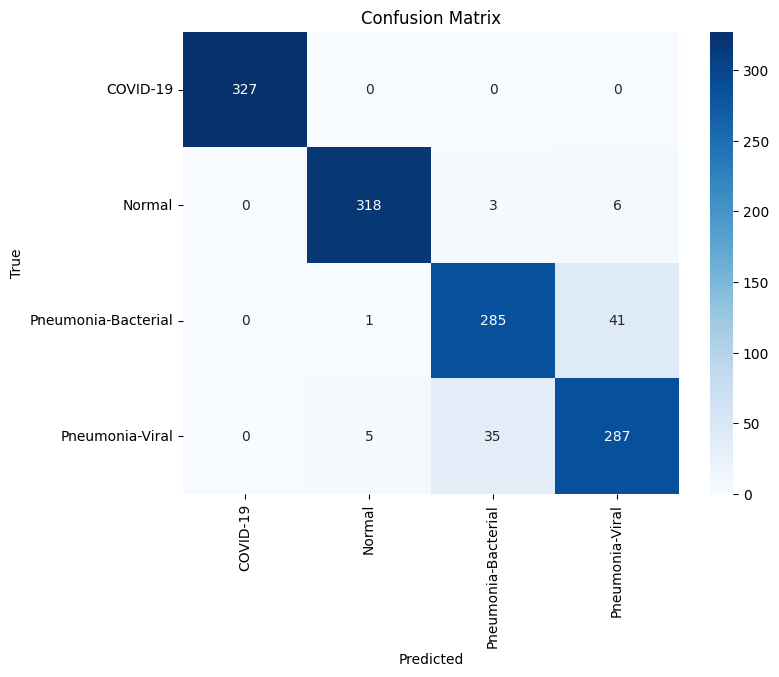

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the test set
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true classes for the test set
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']  # Adjust these based on your actual class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


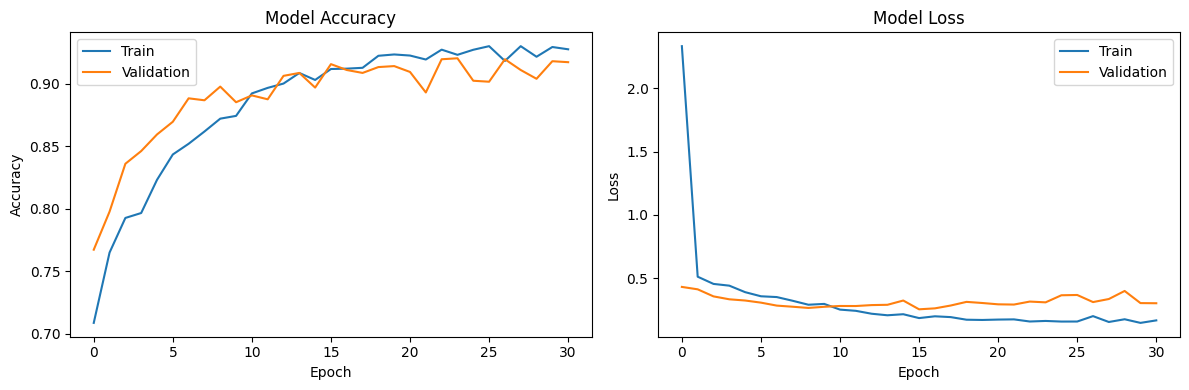

In [44]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'weighted_history' is the history object returned by model.fit()
plot_metrics(history)


1308/1308 [==============================] - 19s 14ms/step


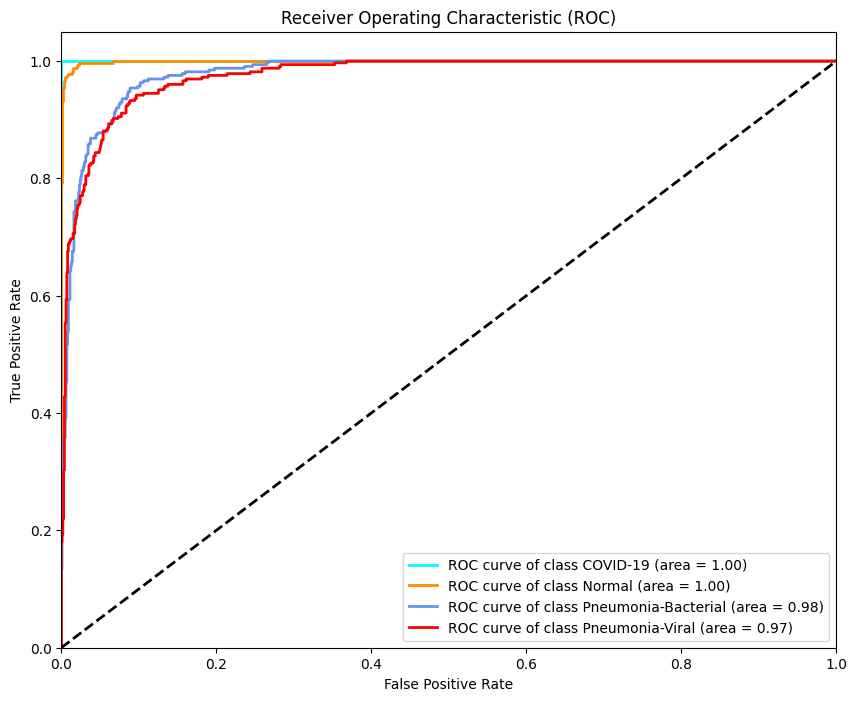

In [45]:
# Import necessary libraries for ROC AUC visualization
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Binarize the true labels for ROC AUC calculation
from sklearn.preprocessing import label_binarize
class_labels = list(test_generator.class_indices.keys())
n_classes = len(class_labels)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()